In [1]:
import numpy as np
import matplotlib.pyplot as plt

from visualization_toolkit.plots.boxplot import boxplot
from visualization_toolkit.adapters.mse_experiment import mse_experiment
from visualization_toolkit.styles.boxplot import (
    boxprops_filled,
    boxprops_filled_hatched,
)

### Utils

In [2]:
def generate_clean_signals(
    n_signals: int,
    n_samples: int,
    fs: float = 1.0,
):
    t = np.arange(n_samples) / fs
    signals = []

    for _ in range(n_signals):
        x = np.sin(2 * np.pi * 0.05 * t) + 0.5 * np.sin(2 * np.pi * 0.12 * t)
        signals.append(x)

    return np.array(signals)


def add_noise(signal: np.ndarray, ratio: float) -> np.ndarray:
    """
    Adds noise with a specified ratio of signal to noise ratio (sigma_signal / sigma_noise).

    Parameters:
        signal: The original signal.
        ratio: The desired sigma_signal / sigma_noise ratio (for example, 10 = noise 10 times weaker).

    Returns:
        A noisy signal, noise.
    """
    sigma_signal = np.std(signal, ddof=1)
    sigma_noise = sigma_signal / ratio

    noise = np.random.normal(0, sigma_noise, size=signal.shape)

    return signal + noise, noise


def generate_noisy_dataset(
    clean_signals,
    noise_ratios,
):
    original = []
    noisy = []

    for ratio in noise_ratios:
        for signal in clean_signals:
            original.append(signal)
            noisy_signal, _ = add_noise(signal, ratio)
            noisy.append(noisy_signal)

    return np.array(original), np.array(noisy)


def moving_average(x, k):
    return np.convolve(x, np.ones(k) / k, mode="same")

### Usage example

In [3]:
noise_ratios = np.arange(0.1, 1.5, 0.5)
n_realizations = 20
n_samples = 512

In [4]:
clean = generate_clean_signals(
    n_realizations,
    n_samples,
)

original_signals, noisy_signals = generate_noisy_dataset(
    clean,
    noise_ratios,
)

In [5]:
signals = {
    "N": noisy_signals,
    "MA-5": np.array([moving_average(x, 5) for x in noisy_signals]),
    "MA-2": np.array([moving_average(x, 2) for x in noisy_signals]),
}
mse_df = mse_experiment(original_signals, signals, noise_ratios, "noise_ratio")
mse_df["noise_ratio"] = mse_df["noise_ratio"].round(2)
mse_df.head(-5)

,noise_ratio,mse,label,run
0,0.1,56.957303,N,0
1,0.1,60.487747,N,1
2,0.1,51.636855,N,2
3,0.1,63.264455,N,3
4,0.1,60.217726,N,4
...,...,...,...,...
170,1.1,0.275868,MA-2,10
171,1.1,0.286545,MA-2,11
172,1.1,0.271470,MA-2,12
173,1.1,0.266917,MA-2,13


In [6]:
styles = {
    "N": boxprops_filled(),
    "MA-2": boxprops_filled(facecolor="white"),
    "MA-5": boxprops_filled_hatched(hatch="||"),
}

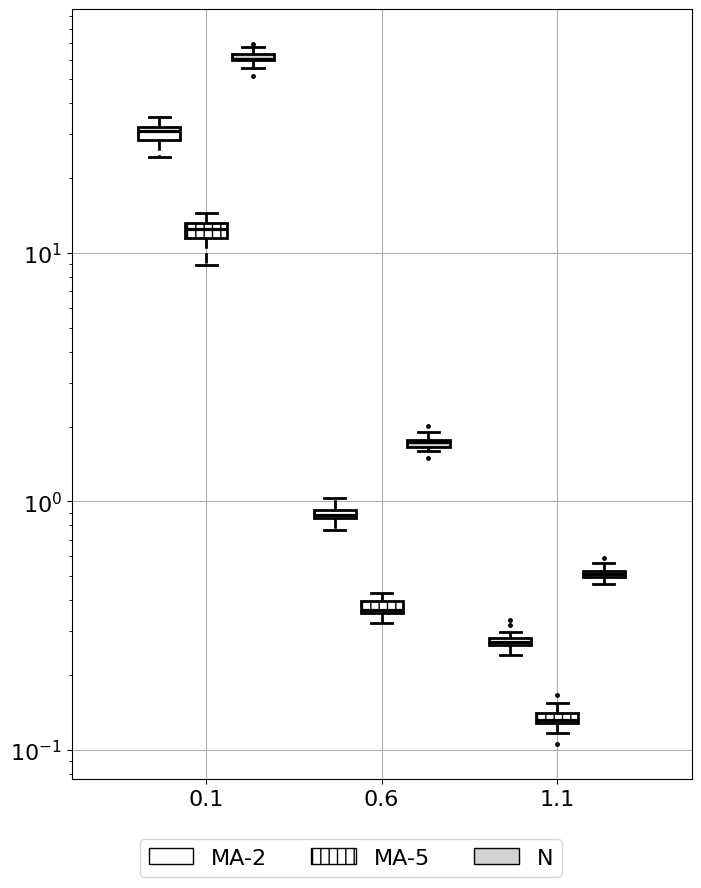

In [7]:
boxplot(mse_df, "noise_ratio", "mse", "label", styles=styles, y_limits=((10 ** (-1), 10 ** (0.3)),), fig_size=(8, 10))
plt.show()

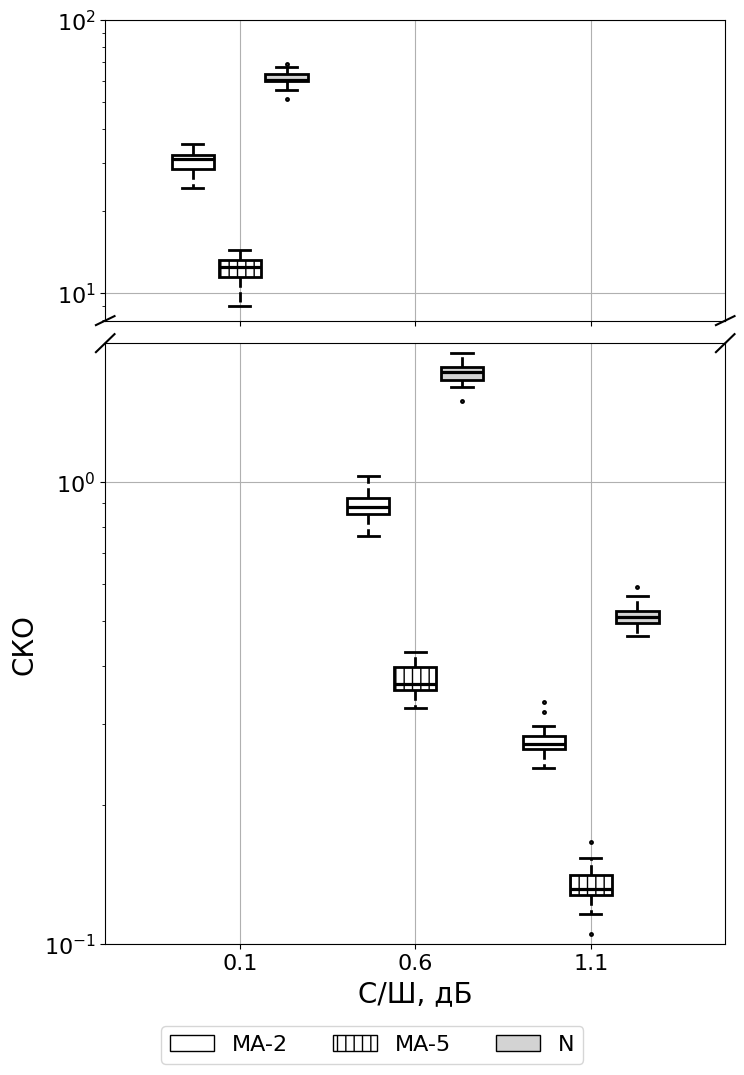

In [8]:
fig, axes = boxplot(
    mse_df,
    "noise_ratio",
    "mse",
    "label",
    x_label="С/Ш, дБ",
    y_label="СКО",
    y_limits=((10 ** (-1), 10 ** (0.3)),(10 ** (0.9), 10 ** (2))),
    styles=styles,
    fig_size=(8, 12),
)
plt.show()